# Homework 6

```yaml
Course:   DS 5001
Module:   06 6 Lab
Topic:    Homework 6
Author:   Ryan Lipps
Date:     2/23/24
```

## Setup

### Configuration

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_hone = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

### Global variables

In [2]:
data_prefix = 'austen-melville'
OHCO = ['book_id', 'chap_id']
bag = 'CHAPS'
colors = "YlGnBu"
tf_agg = 'sum'
pos_list = ['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']

### Imports

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch

### Load data

In [4]:
LIB = pd.read_csv(f"{output_dir}/{data_prefix}-LIB.csv").set_index('book_id')
CORPUS = pd.read_csv(f'{output_dir}/{data_prefix}-CORPUS.csv').set_index('book_id')

#### Format tables

##### Add date to LIB

In [5]:
LIB.head()

,source_file_path,author,title,chap_regex,book_len,n_chaps
book_id,,,,,,
105,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",PERSUASION,^Chapter\s+\d+$,83624,24
121,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",NORTHANGER ABBEY,^CHAPTER\s+\d+$,77601,31
141,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",MANSFIELD PARK,^CHAPTER\s+[IVXLCM]+$,160378,48
158,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",EMMA,^\s*CHAPTER\s+[IVXLCM]+\s*$,160926,55
161,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",SENSE AND SENSIBILITY,^CHAPTER\s+\d+$,119873,50


In [6]:
pub_dict = {'book_id':[158,946,1212,141,121,105,1342,161],
             'pub_year':[1815,1794,1790,1814,1803,1818,1813,1811]
}

In [7]:
LIB['pub_year'] = 0
LIB.head()

,source_file_path,author,title,chap_regex,book_len,n_chaps,pub_year
book_id,,,,,,,
105,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",PERSUASION,^Chapter\s+\d+$,83624,24,0
121,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",NORTHANGER ABBEY,^CHAPTER\s+\d+$,77601,31,0
141,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",MANSFIELD PARK,^CHAPTER\s+[IVXLCM]+$,160378,48,0
158,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",EMMA,^\s*CHAPTER\s+[IVXLCM]+\s*$,160926,55,0
161,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",SENSE AND SENSIBILITY,^CHAPTER\s+\d+$,119873,50,0


In [8]:
AUSTEN_LIB = LIB.loc[list(pub_dict.get('book_id'))]
AUSTEN_LIB

,source_file_path,author,title,chap_regex,book_len,n_chaps,pub_year
book_id,,,,,,,
158,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",EMMA,^\s*CHAPTER\s+[IVXLCM]+\s*$,160926,55,0
946,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",LADY SUSAN,^\s*[IVXLCM]+\s*$,23116,41,0
1212,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",LOVE AND FREINDSHIP SIC,^\s*LETTER .* to .*$,33265,24,0
141,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",MANSFIELD PARK,^CHAPTER\s+[IVXLCM]+$,160378,48,0
121,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",NORTHANGER ABBEY,^CHAPTER\s+\d+$,77601,31,0
105,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",PERSUASION,^Chapter\s+\d+$,83624,24,0
1342,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",PRIDE AND PREJUDICE,^Chapter\s+\d+$,122126,61,0
161,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",SENSE AND SENSIBILITY,^CHAPTER\s+\d+$,119873,50,0


In [9]:
AUSTEN_LIB.loc[list(pub_dict.get('book_id')), 'pub_year'] = pub_dict.get('pub_year')
AUSTEN_LIB['pub_year'] = AUSTEN_LIB['pub_year'].astype('int')

#### Make sure LIB AUSTEN_LIB is ordered to match collapsed TFIDF ordering later

In [23]:
AUSTEN_LIB = AUSTEN_LIB.sort_index(ascending=True)
AUSTEN_LIB

,source_file_path,author,title,chap_regex,book_len,n_chaps,pub_year,label
book_id,,,,,,,,
105,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",PERSUASION,^Chapter\s+\d+$,83624,24,1818,Austen: Persuasion (1818)
121,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",NORTHANGER ABBEY,^CHAPTER\s+\d+$,77601,31,1803,Austen: Northanger Abbey (1803)
141,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",MANSFIELD PARK,^CHAPTER\s+[IVXLCM]+$,160378,48,1814,Austen: Mansfield Park (1814)
158,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",EMMA,^\s*CHAPTER\s+[IVXLCM]+\s*$,160926,55,1815,Austen: Emma (1815)
161,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",SENSE AND SENSIBILITY,^CHAPTER\s+\d+$,119873,50,1811,Austen: Sense And Sensibilit (1811)
946,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",LADY SUSAN,^\s*[IVXLCM]+\s*$,23116,41,1794,Austen: Lady Susan (1794)
1212,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",LOVE AND FREINDSHIP SIC,^\s*LETTER .* to .*$,33265,24,1790,Austen: Love And Freindship (1790)
1342,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",PRIDE AND PREJUDICE,^Chapter\s+\d+$,122126,61,1813,Austen: Pride And Prejudice (1813)


#### Create LIB label

In [10]:
AUSTEN_LIB['label'] = AUSTEN_LIB.author.str.split(', ').str[0] + ': ' +  AUSTEN_LIB.title.str[:20] + ' (' + AUSTEN_LIB.pub_year.astype('str') + ')'
AUSTEN_LIB['label'] = AUSTEN_LIB.label.str.title()
AUSTEN_LIB.head()

,source_file_path,author,title,chap_regex,book_len,n_chaps,pub_year,label
book_id,,,,,,,,
158,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",EMMA,^\s*CHAPTER\s+[IVXLCM]+\s*$,160926,55,1815,Austen: Emma (1815)
946,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",LADY SUSAN,^\s*[IVXLCM]+\s*$,23116,41,1794,Austen: Lady Susan (1794)
1212,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",LOVE AND FREINDSHIP SIC,^\s*LETTER .* to .*$,33265,24,1790,Austen: Love And Freindship (1790)
141,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",MANSFIELD PARK,^CHAPTER\s+[IVXLCM]+$,160378,48,1814,Austen: Mansfield Park (1814)
121,/Users/ryanlipps/Documents/MSDS/DS5001/data/gu...,"AUSTEN, JANE",NORTHANGER ABBEY,^CHAPTER\s+\d+$,77601,31,1803,Austen: Northanger Abbey (1803)


In [11]:
CORPUS = CORPUS.reset_index()
CORPUS = CORPUS.set_index(['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']).dropna()
CORPUS.head()

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                             
105     1       1        0        0               ('Sir', 'NNP')  NNP   
                                  1            ('Walter', 'NNP')  NNP   
                                  2           ('Elliot,', 'NNP')  NNP   
                                  3                 ('of', 'IN')   IN   
                                  4          ('Kellynch', 'NNP')  NNP   

                                            token_str  term_str pos_group  
book_id chap_id para_num sent_num token_num                                
105     1       1        0        0               Sir       sir        NN  
                                  1            Walter    walter        NN  
                                  2           Elliot,    elliot        NN  
                                  3                of        of        IN  
                                  4          Kellynch  kellynch        NN

### Functions

#### Bag of Words function

In [12]:
def get_BOW(corpus:pd.DataFrame, level:str):
    '''
    Function to get bag of words from a corpus

    Corpus here is loosely defined, as this function will work provided the `level` parameter is in the multi-index of `corpus`

    PARAMETERS:

    `corpus` - pandas DataFrame of body of work. It must be multi-indexed by an OHCO

    `level` - string of OHCO to group by for bags

    OUTPUTS:

    pandas DataFrame of bag of words grouiped by `level`

    EXAMPLE:

    `BOW = get_BOW(CORPUS, 'chap_id')`
    '''
    # Get multi-index from `corpus` df
    idx = list(corpus.index.names)

    # Check to see that `level` exists in `corpus` OHCO
    # Raise error if not
    if (level not in idx):
        raise KeyError (f'{level} not found in corpus OHCO')

    # Split-apply-combine to generate BOW grouped by `level`
    return corpus.groupby(idx[:idx.index(level)+1]+['term_str'])\
        .term_str\
        .count()\
        .to_frame('n')

In [13]:
def get_TFIDF(bow:pd.DataFrame, tf_type:str):
    '''
    Function to compute TFIDF and DFIDF for a given bag of words DataFrame

    PARAMETERS:

    `bow` - pandas DataFrame representation of bag of words
    
    `tf_type` - string of term frequency type to use. Options are currently:\n
                sum, max, log, raw, double_norm (defaults to k=1), and binary

    OUTPUTS:
    
    tf-idf vectorized DataFrame
    df-idf vectorized DataFrame

    EXAMPLE:
    `TFIDF = get_TFIDF(BOW, 'max')`
    '''

    DTCM = bow.n.unstack(fill_value=0)

    # Term frequency calculation dictionary
    if tf_type == 'sum':
        TF = DTCM.T / DTCM.T.sum()

    elif tf_type == 'max':
        TF = DTCM.T / DTCM.T.max()
        
    elif tf_type == 'log':
        TF = np.log2(1 + DTCM.T)
        
    elif tf_type == 'raw':
        TF = DTCM.T
        
    elif tf_type == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        
    elif tf_type == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
        
    TF = TF.T
    
    # Calculate document frequency
    DF = DTCM.astype('bool').sum()
    
    # Calculate number of documents
    N = DTCM.shape[0]

    # idf calculations
    IDF = np.log2(N / DF)
    
    #TFIDF = TF*IDF

    return (TF*IDF), (DF*IDF)

## Create AUSTEN tables

In [14]:
austen_books = list(LIB.query('author == "AUSTEN, JANE"').index)
AUSTEN = CORPUS.query(f'book_id in {austen_books}')
AUSTEN.head()

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                             
105     1       1        0        0               ('Sir', 'NNP')  NNP   
                                  1            ('Walter', 'NNP')  NNP   
                                  2           ('Elliot,', 'NNP')  NNP   
                                  3                 ('of', 'IN')   IN   
                                  4          ('Kellynch', 'NNP')  NNP   

                                            token_str  term_str pos_group  
book_id chap_id para_num sent_num token_num                                
105     1       1        0        0               Sir       sir        NN  
                                  1            Walter    walter        NN  
                                  2           Elliot,    elliot        NN  
                                  3                of        of        IN  
                                  4          Kellynch  kellynch        NN

In [15]:
AUSTEN_VOCAB = AUSTEN\
    .term_str\
        .value_counts()\
        .to_frame('n')\
        .sort_index()
AUSTEN_VOCAB.index_name = 'term_str'
AUSTEN_VOCAB['n_chars'] = AUSTEN_VOCAB.index.str.len()
AUSTEN_VOCAB['p'] = AUSTEN_VOCAB.n / AUSTEN_VOCAB.n.sum()
AUSTEN_VOCAB['i'] = -np.log2(AUSTEN_VOCAB.p)
AUSTEN_VOCAB['max_pos'] = AUSTEN[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
AUSTEN_VOCAB.head()

,n,n_chars,p,i,max_pos
term_str,,,,,
0,2,1,0.000003,18.574505,CD
1,3,1,0.000004,17.989542,CD
10,4,2,0.000005,17.574505,CD
10000,2,5,0.000003,18.574505,CD
10th,2,4,0.000003,18.574505,CD


### Compute Chapter-max TF and DF IDFs

In [16]:
TFIDF, dfidf = get_TFIDF(get_BOW(AUSTEN, 'chap_id'), 'max')
TFIDF.head()

term_str           0         1   10  10000  10th  11th   12  12th  1399  13th  \
book_id chap_id                                                                 
105     1        0.0  0.119092  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        2        0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        3        0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        4        0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        5        0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   

term_str         ...  youthful  youths  yrs         z      zeal   zealous  \
book_id chap_id  ...                                                        
105     1        ...  0.043417     0.0  0.0  0.067611  0.000000  0.000000   
        2        ...  0.000000     0.0  0.0  0.000000  0.000000  0.061689   
        3        ...  0.000000     0.0  0.0  0.000000  0.036998  0.000000   
        4        ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
        5        ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   

term_str         zealously  zephyr  zigzags  ł20000  
book_id chap_id                                      
105     1              0.0     0.0      0.0     0.0  
        2              0.0     0.0      0.0     0.0  
        3              0.0     0.0      0.0     0.0  
        4              0.0     0.0      0.0     0.0  
        5              0.0     0.0      0.0     0.0  

[5 rows x 14745 columns]

In [17]:
dfidf.head()

term_str
0         8.383704
1        14.767409
10       20.396225
10000     8.383704
10th     14.767409
dtype: float64

In [18]:
AUSTEN_VOCAB['dfidf'] = dfidf

### Generate 1000 significant terms by dfidf, filtered by POS list

In [19]:
sig_terms = list(AUSTEN_VOCAB.query(f'max_pos in {pos_list}')\
    .sort_values('dfidf', ascending=False)[:1000]\
    .index)
sig_terms[0:10], len(sig_terms)

(['stay',
  'greatest',
  'respect',
  'forward',
  'thinking',
  'assure',
  'fortune',
  'marriage',
  'keep',
  'new'],
 1000)

### Filter TFIDF matrix

In [20]:
TFIDF_SUB = TFIDF[TFIDF.columns.intersection(sig_terms)]
TFIDF_SUB.head()

term_str             able   absence  absolutely  accept  accepted   account  \
book_id chap_id                                                               
105     1        0.006748  0.000000     0.00000     0.0  0.000000  0.000000   
        2        0.008902  0.000000     0.00000     0.0  0.000000  0.000000   
        3        0.000000  0.000000     0.00000     0.0  0.000000  0.008123   
        4        0.000000  0.000000     0.00000     0.0  0.033899  0.000000   
        5        0.012128  0.029111     0.01443     0.0  0.000000  0.035610   

term_str         acknowledge  acknowledged  acquaintance  acquainted  ...  \
book_id chap_id                                                       ...   
105     1                0.0      0.018865      0.031429    0.000000  ...   
        2                0.0      0.000000      0.010365    0.000000  ...   
        3                0.0      0.000000      0.000000    0.014866  ...   
        4                0.0      0.000000      0.025640    0.047335  ...   
        5                0.0      0.000000      0.007060    0.013034  ...   

term_str         written     wrong     wrote      year     years       yes  \
book_id chap_id                                                              
105     1            0.0  0.000000  0.000000  0.024409  0.089561  0.000000   
        2            0.0  0.000000  0.000000  0.000000  0.026254  0.000000   
        3            0.0  0.000000  0.000000  0.012507  0.030594  0.006852   
        4            0.0  0.026202  0.000000  0.019912  0.016236  0.000000   
        5            0.0  0.028861  0.018669  0.000000  0.008942  0.018024   

term_str         yesterday   younger     yours     youth  
book_id chap_id                                           
105     1         0.000000  0.021639  0.000000  0.066992  
        2         0.000000  0.000000  0.000000  0.000000  
        3         0.000000  0.000000  0.015503  0.045769  
        4         0.000000  0.035306  0.000000  0.109302  
        5         0.034222  0.000000  0.000000  0.000000  

[5 rows x 1000 columns]

### Collapse TFIDF_SUB

In [21]:
TFIDF_SUB = TFIDF_SUB.groupby(OHCO[:1]).mean()
TFIDF_SUB

term_str,able,absence,absolutely,accept,accepted,account,acknowledge,acknowledged,acquaintance,acquainted,...,written,wrong,wrote,year,years,yes,yesterday,younger,yours,youth
book_id,,,,,,,,,,,,,,,,,,,,,
105,0.007063,0.004201,0.003214,0.004572,0.002638,0.009493,0.005300,0.006599,0.019410,0.013924,...,0.006491,0.006005,0.002818,0.011354,0.021086,0.010142,0.009706,0.006217,0.006201,0.014419
121,0.008429,0.010450,0.001819,0.001318,0.003574,0.009531,0.005313,0.005972,0.017537,0.005929,...,0.007638,0.009131,0.000698,0.006563,0.011367,0.019185,0.003479,0.005773,0.007926,0.004474
141,0.008697,0.010947,0.008565,0.007065,0.007090,0.007739,0.004198,0.007728,0.006527,0.003138,...,0.006807,0.013484,0.007317,0.011601,0.011221,0.014118,0.005551,0.005520,0.005620,0.002779
158,0.011177,0.006547,0.011217,0.005475,0.004443,0.009684,0.007146,0.005346,0.011272,0.009450,...,0.010124,0.013932,0.009225,0.007745,0.013004,0.017290,0.009982,0.001067,0.001932,0.006102
161,0.007654,0.005259,0.004046,0.005774,0.004277,0.008991,0.006562,0.005761,0.013762,0.010964,...,0.006569,0.007859,0.006506,0.017544,0.014594,0.011022,0.006846,0.004386,0.005463,0.004007
946,0.009830,0.005737,0.012270,0.008060,0.005486,0.016031,0.002116,0.001841,0.003857,0.015176,...,0.009079,0.001836,0.006179,0.000753,0.010577,0.000000,0.015026,0.002618,0.046576,0.003555
1212,0.006946,0.004946,0.000234,0.007987,0.000919,0.005157,0.000916,0.000000,0.010702,0.011047,...,0.003116,0.000000,0.002540,0.008430,0.019947,0.007384,0.005747,0.005115,0.019138,0.026596
1342,0.009329,0.011327,0.007164,0.009829,0.009426,0.006890,0.004837,0.009772,0.010445,0.008634,...,0.008240,0.006811,0.011127,0.009746,0.008549,0.013016,0.005150,0.017307,0.009408,0.004538


## Compute Norms and Distances

### Compute Norms

In [22]:
L0 = TFIDF_SUB.astype('bool').astype('int')     # Binary (Pseudo L)
L1 = TFIDF_SUB.apply(lambda x: x / x.sum(), 1)  # Probabilistic
L2 = TFIDF_SUB.apply(lambda x: x / norm(x), 1)  # Pythagorean, AKA Euclidean

### Create pairs

In [24]:
# Create dataframe with cartesian product of books by books
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([AUSTEN_LIB.index.tolist(), AUSTEN_LIB.index.tolist()])).reset_index()

# Keep only unique pairs of different books
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])

# Name index cols
PAIRS.index.names = ['doc_a', 'doc_b']

In [25]:
PAIRS

Empty DataFrame
Columns: []
Index: [(105, 121), (105, 141), (105, 158), (105, 161), (105, 946), (105, 1212), (105, 1342), (121, 141), (121, 158), (121, 161), (121, 946), (121, 1212), (121, 1342), (141, 158), (141, 161), (141, 946), (141, 1212), (141, 1342), (158, 161), (158, 946), (158, 1212), (158, 1342), (161, 946), (161, 1212), (161, 1342), (946, 1212), (946, 1342), (1212, 1342)]

### Compute Distances

In [26]:
PAIRS['cityblock'] = pdist(TFIDF_SUB, 'cityblock')
PAIRS['cosine'] = pdist(TFIDF_SUB, 'cosine')
PAIRS['euclidean'] = pdist(L2, 'euclidean')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['js'] = pdist(L1, 'jensenshannon')  

In [27]:
PAIRS

cityblock    cosine  euclidean   jaccard        js
doc_a doc_b                                                    
105   121     3.548524  0.169794   0.582742  0.009009  0.231993
      141     2.949737  0.125444   0.500887  0.006000  0.192337
      158     3.230510  0.134878   0.519380  0.010000  0.199684
      161     3.701946  0.167215   0.578299  0.006000  0.227238
      946     5.352625  0.355616   0.843346  0.126000  0.369170
      1212    5.464989  0.363679   0.852853  0.108216  0.377548
      1342    3.608176  0.155916   0.558419  0.007000  0.218743
121   141     3.263363  0.157145   0.560615  0.007000  0.215690
      158     3.652779  0.176385   0.593944  0.011000  0.227617
      161     3.535098  0.167701   0.579140  0.007000  0.217987
      946     5.171677  0.335337   0.818947  0.125125  0.360517
      1212    5.388654  0.366538   0.856198  0.109218  0.374903
      1342    3.514433  0.155316   0.557344  0.008000  0.215576
141   158     2.910334  0.135824   0.521199  0.004004  0.184808
      161     3.572197  0.174946   0.591516  0.002000  0.218934
      946     4.919042  0.309255   0.786454  0.122000  0.344615
      1212    5.456716  0.371252   0.861687  0.108000  0.375482
      1342    3.294417  0.131312   0.512469  0.003000  0.196659
158   161     3.760744  0.166164   0.576479  0.006000  0.220954
      946     5.360754  0.325164   0.806430  0.126000  0.347904
      1212    5.828175  0.364366   0.853657  0.108216  0.375074
      1342    3.606993  0.164952   0.574372  0.007000  0.217466
161   946     5.139736  0.309547   0.786825  0.122000  0.346270
      1212    5.306156  0.310933   0.788584  0.108000  0.351448
      1342    3.201975  0.133381   0.516489  0.003000  0.195426
946   1212    5.567200  0.420639   0.917213  0.189990  0.421327
      1342    4.998955  0.286872   0.757459  0.119238  0.334455
1212  1342    5.395740  0.319324   0.799154  0.109000  0.352829

## Hierarchical clustering

### Dendrogram Function

In [29]:
AUSTEN_LIB.label.values

array(['Austen: Persuasion (1818)', 'Austen: Northanger Abbey (1803)',
       'Austen: Mansfield Park (1814)', 'Austen: Emma (1815)',
       'Austen: Sense And Sensibilit (1811)', 'Austen: Lady Susan (1794)',
       'Austen: Love And Freindship  (1790)',
       'Austen: Pride And Prejudice (1813)'], dtype=object)

In [30]:
def hac(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):
    '''
    Function to graph hierarchical cluster dendrogram

    PARAMETERS:

    sims - series of distances to use

    linkage_method - string of linkage measure to use, defaults to "complete"


    '''
    # Generate the clustering
    tree = sch.linkage(sims, method=linkage_method)
    
    # Get labels for the leaves
    labels = AUSTEN_LIB.label.values
    
    # Create a figure 
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    
    # Create a dendrogram with the tree
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    
    # Change the appearance of ticks, tick labels, and gridlines
    plt.tick_params(axis='both', which='major', labelsize=14)

## Dendrograms

### Cityblock Weighted

<Figure size 640x480 with 0 Axes>

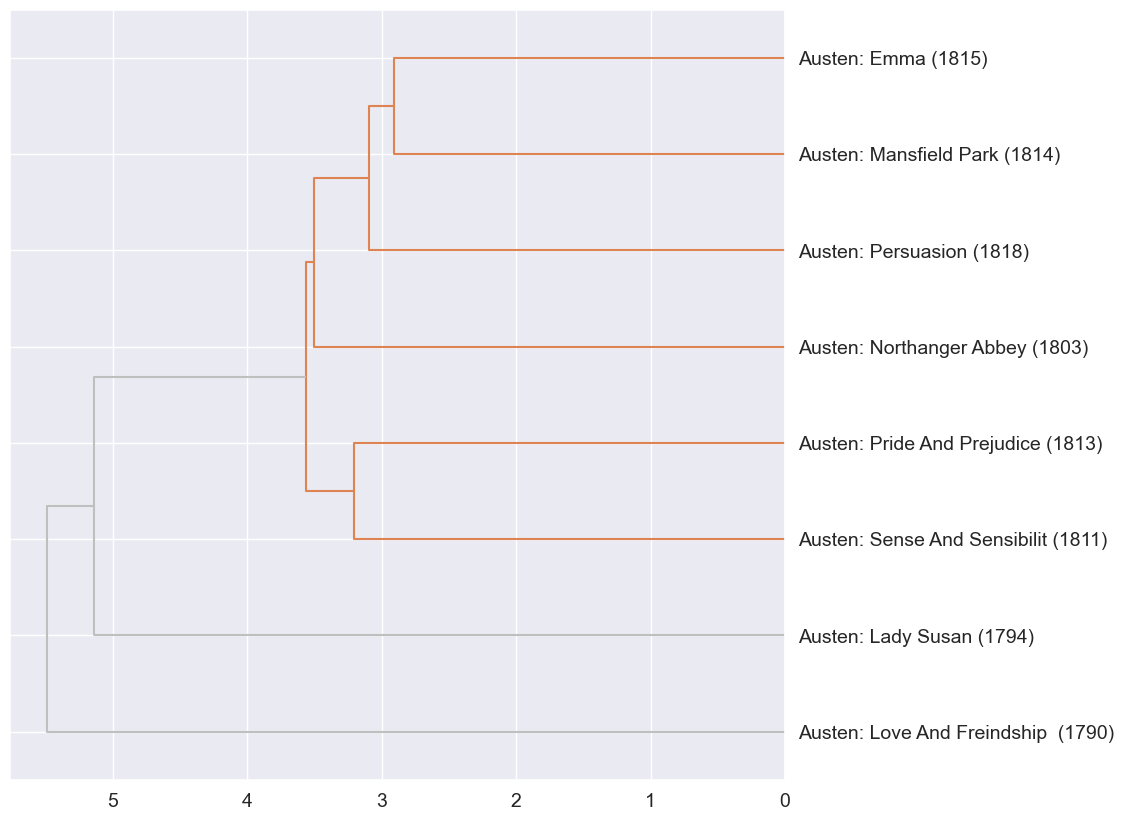

In [31]:
hac(PAIRS.cityblock, linkage_method='weighted', color_thresh=5)

### Cosine Ward

<Figure size 640x480 with 0 Axes>

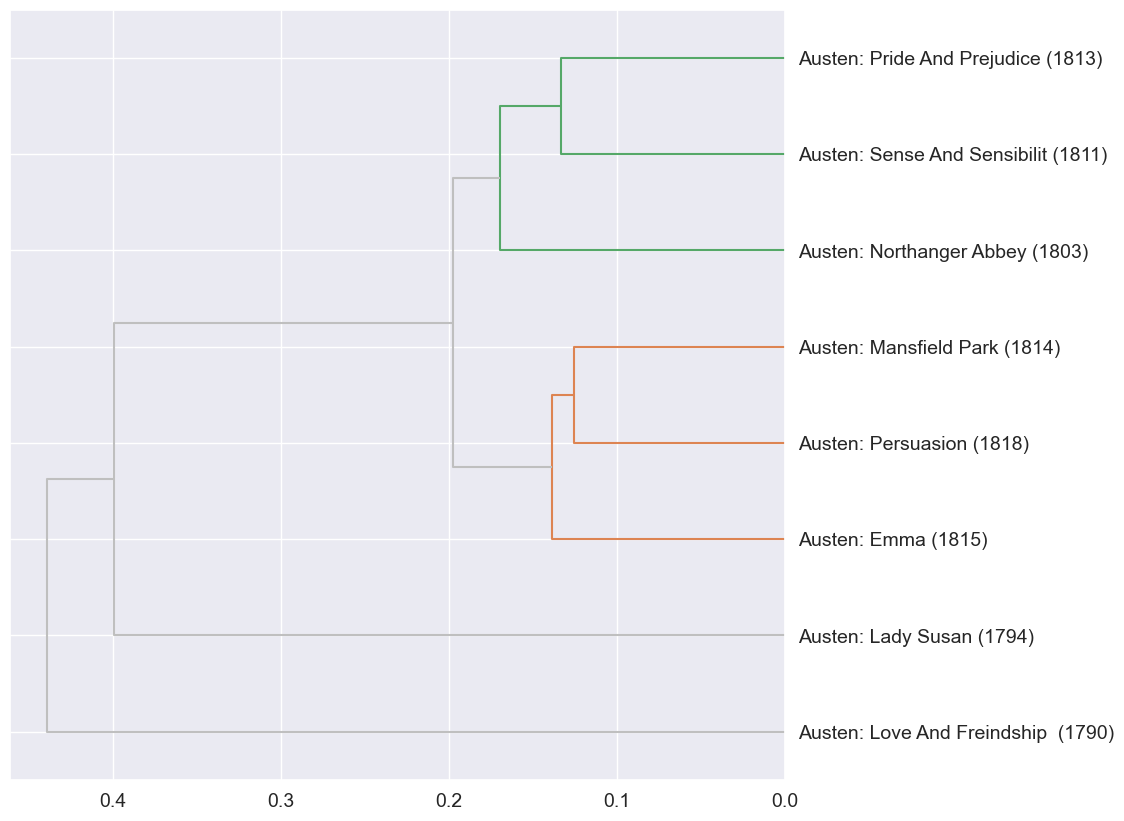

In [32]:
hac(PAIRS.cosine, linkage_method='ward', color_thresh=0.18)

### Euclidean Ward

<Figure size 640x480 with 0 Axes>

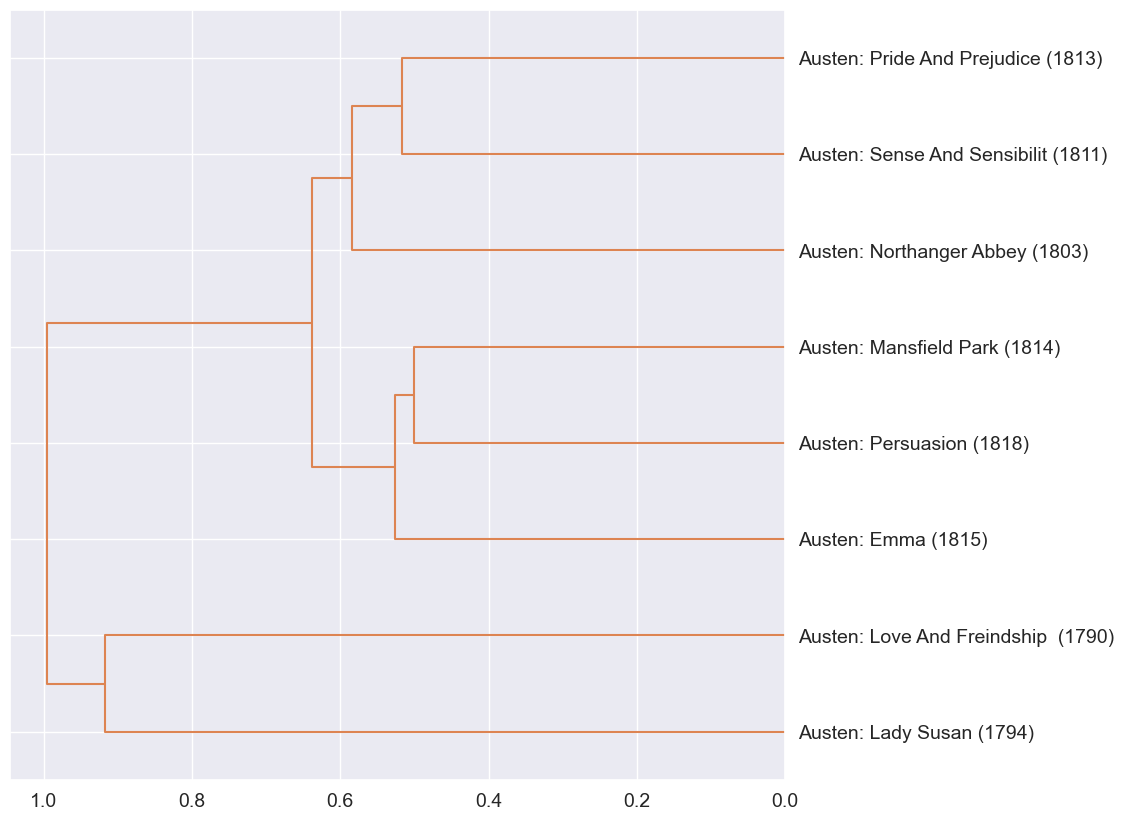

In [33]:
hac(PAIRS.euclidean, linkage_method='ward', color_thresh=5)

### Jaccard Weighted

<Figure size 640x480 with 0 Axes>

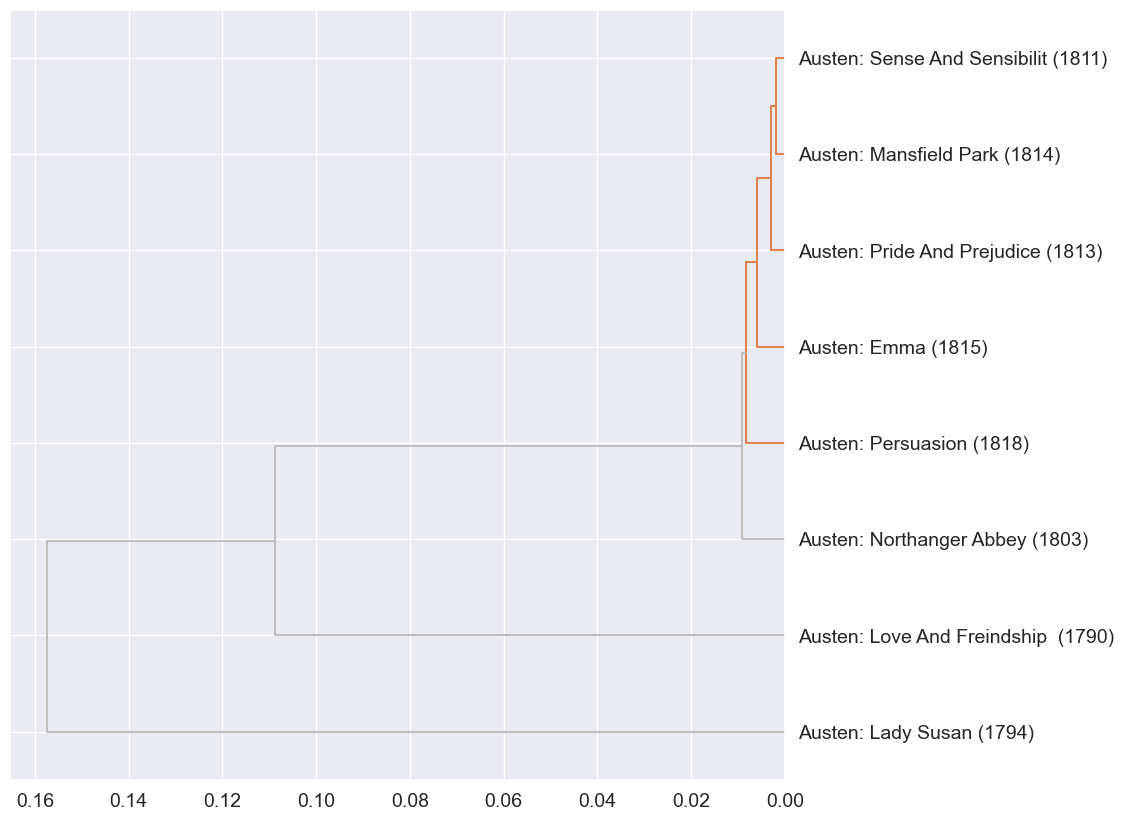

In [49]:
hac(PAIRS.jaccard, linkage_method='weighted', color_thresh=0.009)

### JensShannon Weighted

<Figure size 640x480 with 0 Axes>

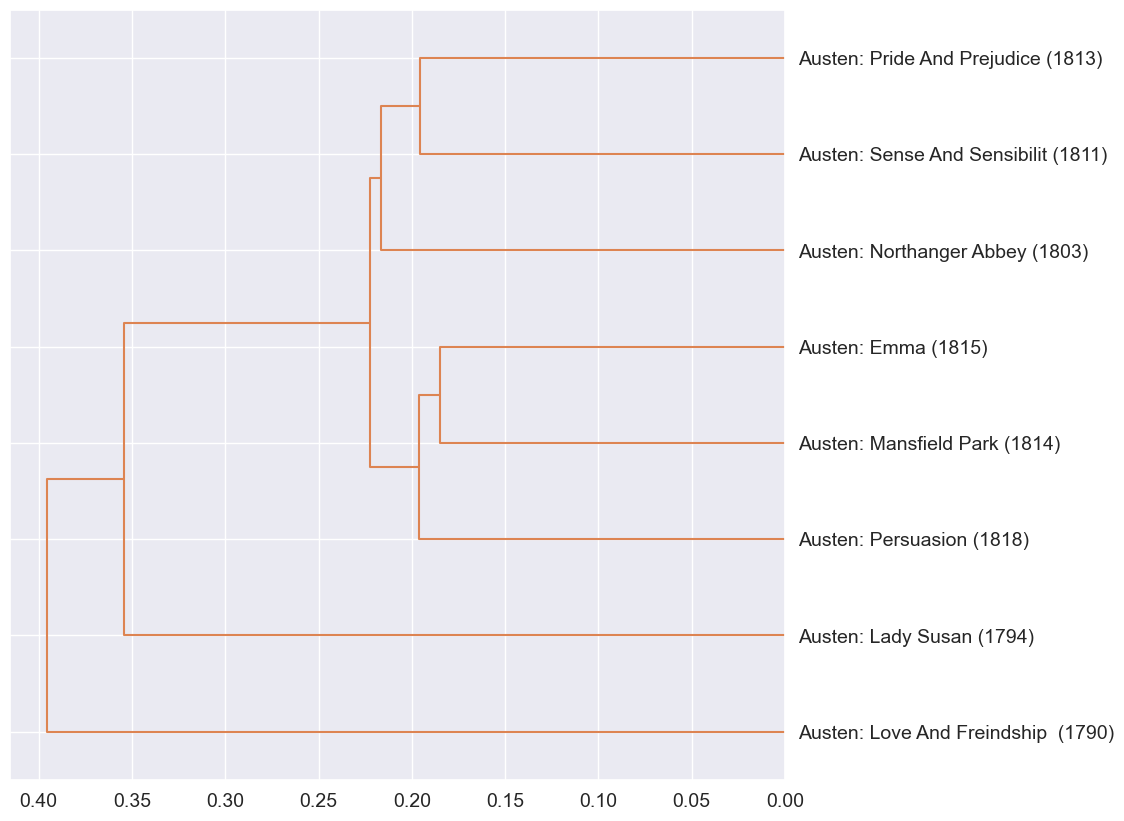

In [35]:
hac(PAIRS.js, linkage_method='weighted', color_thresh=5)

## Question 1:
What are the top 10 nouns by DFIDF, sorted in descending order? Include plural nouns, but don't include proper nouns.

### Answer 1:

In [36]:
AUSTEN_VOCAB.query('max_pos in ["NN", "NNS"]').sort_values('dfidf', ascending=False).head(10)

,n,n_chars,p,i,max_pos,dfidf
term_str,,,,,,
respect,174,7,0.000223,12.131561,NN,177.266344
fortune,222,7,0.000284,11.780089,NN,177.261968
marriage,246,8,0.000315,11.631990,NN,177.261968
ladies,240,6,0.000307,11.667614,NNS,177.258990
question,171,8,0.000219,12.156652,NN,177.258990
farther,181,7,0.000232,12.074659,NN,177.240001
behaviour,200,9,0.000256,11.930649,NN,177.240001
advantage,166,9,0.000213,12.199465,NN,177.217644
voice,228,5,0.000292,11.741615,NN,177.209470


## Question 2:
Grouping your `TFIDF` results by book, and taking the mean `TFIDF` of all terms per book, what is Austen's most "significant" book? This value is computed from the `TFIDF` matrix your function returned.

### Answer 2:

In [37]:
TFIDF_SUB.stack().groupby('book_id').mean().sort_values(ascending=False)

book_id
158     0.008163
1342    0.008039
161     0.007963
141     0.007331
121     0.007267
105     0.007227
946     0.006310
1212    0.006030
dtype: float64

In [38]:
AUSTEN_LIB.loc[158].title

'EMMA'

In [39]:
TFIDF.stack().groupby('book_id').mean().sort_values(ascending=False)

book_id
121     0.001851
158     0.001826
105     0.001821
1212    0.001806
161     0.001785
1342    0.001758
141     0.001731
946     0.001524
dtype: float64

In [40]:
AUSTEN_LIB.loc[121].title

'NORTHANGER ABBEY'

## Question 3:
Using the dendograms you generated, which distance measure most clearly distinguishes Austen's two youthful works from her later works? That is, which measure show the greatest separation between the first two work and the rest? Note that the two youthful works were published before 1800.

### Answer 3:

**Cityblock with weighted linkage**

## Question 4:
Do any of the distance measures produce dendrograms with works sorted in the exact order of their publication years? 

### Answer 4:
**No**

## Question 5:
Some literary critics believe that Northanger Abbey is, among Austen's mature works, the one that most resembles her juvenalia, i.e. her two works written as a young adult. Which distance measure dendrograms appear to corroborate this thesis? In other words, do any of them show that Northanger Abbey is closer to her juvenalia than the her other adult works? 

### Answer 5:
**Jaccard with weighted linkage**